# 1 - Setup

In [11]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from PIL import Image
import tqdm.notebook as tq
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tf
from torch import nn
from torchmetrics import Accuracy, F1Score, Recall, Precision
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision.ops import sigmoid_focal_loss
from torchinfo import summary
from accelerate import Accelerator

# 2 - Visualizing Processing Techniques

### These techniques make training converge faster (get better results in less epochs)

In [12]:
img = Image.open("/kaggle/input/magnetic-tile-defect-3/Train/Train/Crack/Crack (39).jpg")

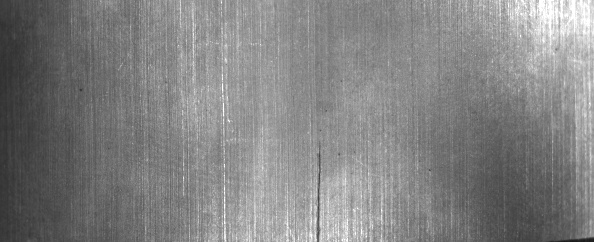

In [13]:
img

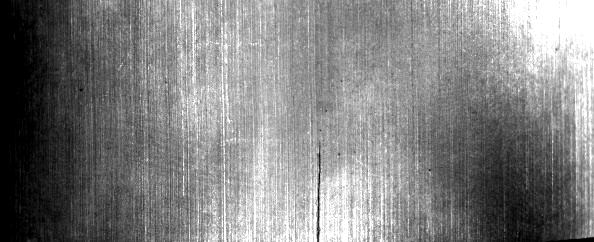

In [14]:
tf.functional.adjust_contrast(img,2)

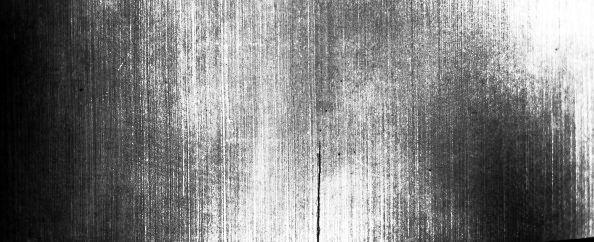

In [15]:
tf.RandomEqualize(1)(img)

# 3 - Preparing the Data (splitting and processing)
### Each image is concatenated with 2 modified versions of it: one with increased contrast and one with equalization.
### We used random horizontal flips and random vertical flips as augmentation.

In [16]:
def get_dfs(path="/kaggle/input/magnetic-tile-defect-3/Train/Train",train_prop=0.8):
    files = []
    for c in os.listdir(path):
        files.extend(os.listdir(os.path.join(path,c)))
    files = pd.Series(files).sample(frac=1).reset_index(drop=True)
    train_ind = int(np.round(len(files)*train_prop))
    traindf = files[:train_ind]
    valdf = files[train_ind:].reset_index(drop=True)
    return traindf, valdf

In [17]:
traindf, valdf = get_dfs()

In [18]:
class mydata(Dataset):
    def __init__(self,path,df,process=True,evaluate=False):
        super().__init__()
        self.process = process
        self.files = df
        self.path = path
        self.classes = ['Blowhole', 'Free', 'Break', 'Uneven', 'Crack']
        self.eval = evaluate
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        c = random.randint(0,4)
        cla = self.classes[c]
        imgpath = random.choice(self.files[self.files.apply(lambda x: cla in x)].reset_index(drop=True))
        c = imgpath.find("(")
        c = imgpath[0:c-1]
        imgpath = os.path.join(self.path,c,imgpath)
        if self.process==True:
            img = Image.open(imgpath).resize((512,512))
            img = tf.RandomHorizontalFlip()(img)
            img = tf.RandomVerticalFlip()(img)
            eq = tf.RandomEqualize(1)(img)
            con = tf.functional.adjust_contrast(img,2)
            img = tf.PILToTensor()(img)/255.0
            con = tf.PILToTensor()(con)/255.0
            eq = tf.PILToTensor()(eq)/255.0
            img = torch.vstack([img,con,eq])
        else:
            img = Image.open(imgpath).convert("RGB").resize((512,512))
            img = tf.RandomHorizontalFlip()(img)
            img = tf.RandomVerticalFlip()(img)
            img = tf.PILToTensor()(img)/255.0
        if self.eval==False:
            return img, self.classes.index(c)
        else:
            return img

In [19]:
traindt = mydata("/kaggle/input/magnetic-tile-defect-3/Train/Train",traindf,process=True)
valdt = mydata("/kaggle/input/magnetic-tile-defect-3/Train/Train",valdf,process=True)

In [20]:
BS = 20
trainloader = DataLoader(traindt,batch_size=BS,shuffle=True)
valloader = DataLoader(valdt,batch_size=1,shuffle=True)

# 4 - The Model: We fine-tuned a pre-trained version of EfficientNetV2

In [21]:
class CNN(nn.Module):
    
    def conv_block(self, nfilters = [16,32], ker_size = [3,3], strides = [1,2]):
        return nn.Sequential(nn.LazyConv2d(nfilters[0], ker_size[0], strides[0]),
                      nn.ReLU(),
                      nn.Dropout2d(p=0.35),
                      nn.LazyConv2d(nfilters[1], ker_size[1], strides[1]),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2),
                      nn.LazyBatchNorm2d())
    
    def linear_block(self, sizes=[256,64], dr=0.2):
        return nn.Sequential(nn.LazyLinear(sizes[0]),
                              nn.ReLU(),
                              nn.Dropout(p=dr),
                              nn.LazyLinear(sizes[1]),
                              nn.ReLU())
    
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(nfilters=[32,64])#ker_size=[2,2])
        self.conv2 = self.conv_block(nfilters=[64,128])
        self.conv3 = self.conv_block(nfilters=[128,256])
        self.embedding = nn.Flatten()
        self.dense = self.linear_block()
        self.classifier = nn.LazyLinear(5)
        
    def forward(self, x, embedding_only=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.embedding(x)
        x = self.dense(x)
        x = self.classifier(x)
        return x

In [22]:
#model = CNN()

In [23]:
#model = torchvision.models.convnext_tiny(weights="DEFAULT")

In [24]:
model = torchvision.models.efficientnet_v2_s(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:02<00:00, 42.3MB/s]


#### Changing the default configuration from 1000 classes to 5 classes

In [25]:
fts = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features=fts, out_features=5)

In [26]:
summary(model, (1,3,320,320))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 5]                    --
├─Sequential: 1-1                                       [1, 1280, 10, 10]         --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 160, 160]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 160, 160]         648
│    │    └─BatchNorm2d: 3-2                            [1, 24, 160, 160]         48
│    │    └─SiLU: 3-3                                   [1, 24, 160, 160]         --
│    └─Sequential: 2-2                                  [1, 24, 160, 160]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 160, 160]         5,232
│    │    └─FusedMBConv: 3-5                            [1, 24, 160, 160]         5,232
│    └─Sequential: 2-3                                  [1, 48, 80, 80]           --
│    │    └─FusedMBConv: 3-6                         

# 5 - Training Parameters and Details

In [27]:
EPOCHS = 10
BS = 20
LR = 1e-3
GRADACC = 3
BEST_MODEL_PATH = "best.pt"

In [28]:
optimizer = Adam(params=model.parameters(), lr=LR)
steps = len(trainloader)
valsteps = len(valloader)
sched = CosineAnnealingLR(optimizer,eta_min=1e-8,T_max=steps*EPOCHS)
loss = nn.CrossEntropyLoss()

acc = Accuracy(num_classes=5,task="multiclass",average='macro').cuda()
f1 = F1Score(num_classes=5,task="multiclass",average='macro').cuda()
rec = Recall(num_classes=5,task="multiclass",average='macro').cuda()
prec = Precision(num_classes=5,task="multiclass",average='macro').cuda()

#### Using the Accelerate library to reduce GPU memory consumption during training

In [29]:
accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=GRADACC)
model, optimizer, sched, trainloader, valloader = accelerator.prepare(model, optimizer, sched, trainloader, valloader)

In [30]:
def training_evaluation(outputs, labels, train_loss, train_acc, train_f1, train_prec, train_rec):
    batchloss = loss(outputs, labels.to(int))
    train_loss += batchloss
    batch_acc = acc(outputs, labels.to(int))
    train_acc += batch_acc
    batch_f1 = f1(outputs, labels.to(int))
    train_f1 += batch_f1
    batch_prec = prec(outputs, labels.to(int))
    train_prec += batch_prec
    batch_rec = rec(outputs, labels.to(int))
    train_rec += batch_rec
    return (batchloss, batch_acc, batch_f1, batch_prec, batch_rec), (train_loss, train_acc, train_f1, train_prec, train_rec)

In [31]:
def validation_evaluation(outputs, labels, val_loss, val_acc, val_f1, val_prec, val_rec):
    val_loss += loss(outputs, labels.to(int))
    val_acc += acc(outputs, labels.to(int))
    val_f1 += f1(outputs, labels.to(int))
    val_prec += prec(outputs, labels.to(int))
    val_rec += rec(outputs, labels.to(int))
    return val_loss, val_acc, val_f1, val_prec, val_rec

In [32]:
def epoch_training():
    bar = tq.tqdm(range(steps))
    train_loss, train_acc, train_f1, train_prec, train_rec = 0, 0, 0, 0, 0
    model.train()
    for batch in trainloader:
        with accelerator.accumulate(model):
            images, labels = batch
            optimizer.zero_grad()
            outputs = model(images)
            batch_metrics, epoch_metrics = training_evaluation(outputs, labels, train_loss, train_acc, train_f1, train_prec, train_rec)
            batchloss, batch_acc, batch_f1, batch_prec, batch_rec = batch_metrics
            train_loss, train_acc, train_f1, train_pred, train_rec = epoch_metrics
            accelerator.backward(batchloss)
            optimizer.step()
            sched.step()
            bar.update(1)
            cur_lr = float('{:.2e}'.format(sched.get_last_lr()[0]))
            logs = {"lr":cur_lr,"batch loss":batchloss.detach().item(), "batch Accuracy":batch_acc.item(), "batch F1":batch_f1.item(), "batch Precision":batch_prec.item(), "batch Recall":batch_rec.item()}
            bar.set_postfix(**logs)
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)
    train_f1 /= len(trainloader)
    train_prec /= len(trainloader)
    train_rec /= len(trainloader)
    print("Training Results:")
    print(f"Average Loss = {train_loss:.2f}\nAverage Accuracy = {train_acc:.2f}\nAverage F1Score = {train_f1:.2f}\nAverage Precision = {train_prec:.2f}\nAverage Recall = {train_rec:.2f}")

In [33]:
def epoch_validation(best_val_f1score):
    model.eval()
    val_loss, val_acc, val_f1, val_prec, val_rec = 0, 0, 0, 0, 0
    for batch in valloader:
        images, labels = batch
        with torch.no_grad():
            outputs = model(images)
            val_loss, val_acc, val_f1, val_prec, val_rec = validation_evaluation(outputs, labels, val_loss, val_acc, val_f1, val_prec, val_rec)
    val_loss /= len(valloader)
    val_acc /= len(valloader)
    val_f1 /= len(valloader)
    val_prec /= len(valloader)
    val_rec /= len(valloader)
    print("Validation Results:")
    print(f"Average Loss = {val_loss:.2f}\nAverage Accuracy = {val_acc:.2f}\nAverage F1Score = {val_f1:.2f}\nAverage Precision = {val_prec:.2f}\nAverage Recall = {val_rec:.2f}")
    if val_f1 > best_val_f1score:
        best_val_f1score = val_f1
        torch.save({'model_state_dict': model.state_dict()}, BEST_MODEL_PATH)
        print("Validation F1Score Improved. Saving Model.")
    print("\n\n")
    return best_val_f1score

In [34]:
def train():
    best_val_f1score = 0
    for e in range(EPOCHS):
        print(f"Epoch {e+1}:")
        epoch_training()
        best_val_f1score = epoch_validation(best_val_f1score)
    accelerator.free_memory()

# 6 - Training, Observing Validation Results and Saving the best version of the Model

In [35]:
train()

Epoch 1:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 1.38
Average Accuracy = 0.40
Average F1Score = 0.37
Average Precision = 0.00
Average Recall = 0.40
Validation Results:
Average Loss = 1.43
Average Accuracy = 0.09
Average F1Score = 0.09
Average Precision = 0.09
Average Recall = 0.09
Validation F1Score Improved. Saving Model.



Epoch 2:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 1.00
Average Accuracy = 0.63
Average F1Score = 0.59
Average Precision = 0.00
Average Recall = 0.63
Validation Results:
Average Loss = 0.76
Average Accuracy = 0.15
Average F1Score = 0.15
Average Precision = 0.15
Average Recall = 0.15
Validation F1Score Improved. Saving Model.



Epoch 3:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.86
Average Accuracy = 0.71
Average F1Score = 0.67
Average Precision = 0.00
Average Recall = 0.71
Validation Results:
Average Loss = 0.79
Average Accuracy = 0.15
Average F1Score = 0.15
Average Precision = 0.15
Average Recall = 0.15
Validation F1Score Improved. Saving Model.



Epoch 4:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.75
Average Accuracy = 0.79
Average F1Score = 0.74
Average Precision = 0.00
Average Recall = 0.79
Validation Results:
Average Loss = 0.68
Average Accuracy = 0.16
Average F1Score = 0.16
Average Precision = 0.16
Average Recall = 0.16
Validation F1Score Improved. Saving Model.



Epoch 5:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.53
Average Accuracy = 0.88
Average F1Score = 0.84
Average Precision = 0.00
Average Recall = 0.88
Validation Results:
Average Loss = 0.62
Average Accuracy = 0.16
Average F1Score = 0.16
Average Precision = 0.16
Average Recall = 0.16
Validation F1Score Improved. Saving Model.



Epoch 6:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.40
Average Accuracy = 0.89
Average F1Score = 0.87
Average Precision = 0.00
Average Recall = 0.89
Validation Results:
Average Loss = 0.31
Average Accuracy = 0.18
Average F1Score = 0.18
Average Precision = 0.18
Average Recall = 0.18
Validation F1Score Improved. Saving Model.



Epoch 7:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.32
Average Accuracy = 0.90
Average F1Score = 0.88
Average Precision = 0.00
Average Recall = 0.90
Validation Results:
Average Loss = 0.24
Average Accuracy = 0.19
Average F1Score = 0.19
Average Precision = 0.19
Average Recall = 0.19
Validation F1Score Improved. Saving Model.



Epoch 8:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.27
Average Accuracy = 0.93
Average F1Score = 0.90
Average Precision = 0.00
Average Recall = 0.93
Validation Results:
Average Loss = 0.13
Average Accuracy = 0.20
Average F1Score = 0.20
Average Precision = 0.20
Average Recall = 0.20
Validation F1Score Improved. Saving Model.



Epoch 9:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.21
Average Accuracy = 0.95
Average F1Score = 0.93
Average Precision = 0.00
Average Recall = 0.95
Validation Results:
Average Loss = 0.21
Average Accuracy = 0.19
Average F1Score = 0.19
Average Precision = 0.19
Average Recall = 0.19



Epoch 10:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.22
Average Accuracy = 0.94
Average F1Score = 0.92
Average Precision = 0.00
Average Recall = 0.94
Validation Results:
Average Loss = 0.21
Average Accuracy = 0.19
Average F1Score = 0.19
Average Precision = 0.19
Average Recall = 0.19





In [36]:
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model=model.eval()

In [37]:
def get_preds_reals(dtt):
    preds = []
    reals = []
    for i in range(len(dtt)):
        sample, c = dtt[i]
        outs = model(sample.unsqueeze(0).cuda()).argmax().item()
        preds.append(outs)
        reals.append(c)
    return preds, reals

p,r = get_preds_reals(traindt)
print(classification_report(r,p))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       122
           1       0.95      0.91      0.93       148
           2       0.92      0.98      0.95       129
           3       1.00      0.98      0.99       125
           4       0.98      1.00      0.99       126

    accuracy                           0.97       650
   macro avg       0.97      0.97      0.97       650
weighted avg       0.97      0.97      0.97       650



# 7 - Training the best version of the model on the entire dataset

In [38]:
def get_full_df(path="/kaggle/input/magnetic-tile-defect-3/Train/Train"):
    files = []
    for c in os.listdir(path):
        files.extend(os.listdir(os.path.join(path,c)))
    files = pd.Series(files).sample(frac=1).reset_index(drop=True)
    return files

fulldf = get_full_df()
fulldt = mydata("/kaggle/input/magnetic-tile-defect-3/Train/Train",traindf,process=True)

In [39]:
def train():
    for e in range(EPOCHS):
        print(f"Epoch {e+1}:")
        epoch_training()
    accelerator.free_memory()

In [40]:
EPOCHS = 15
model = model.train()

In [41]:
train()

Epoch 1:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.23
Average Accuracy = 0.94
Average F1Score = 0.92
Average Precision = 0.00
Average Recall = 0.94
Epoch 2:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.16
Average Accuracy = 0.97
Average F1Score = 0.95
Average Precision = 0.00
Average Recall = 0.97
Epoch 3:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.16
Average Accuracy = 0.96
Average F1Score = 0.95
Average Precision = 0.00
Average Recall = 0.96
Epoch 4:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.14
Average Accuracy = 0.97
Average F1Score = 0.95
Average Precision = 0.00
Average Recall = 0.97
Epoch 5:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.22
Average Accuracy = 0.93
Average F1Score = 0.92
Average Precision = 0.00
Average Recall = 0.93
Epoch 6:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.32
Average Accuracy = 0.91
Average F1Score = 0.88
Average Precision = 0.00
Average Recall = 0.91
Epoch 7:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.42
Average Accuracy = 0.88
Average F1Score = 0.85
Average Precision = 0.00
Average Recall = 0.88
Epoch 8:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.43
Average Accuracy = 0.88
Average F1Score = 0.86
Average Precision = 0.00
Average Recall = 0.88
Epoch 9:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.73
Average Accuracy = 0.77
Average F1Score = 0.73
Average Precision = 0.00
Average Recall = 0.77
Epoch 10:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.59
Average Accuracy = 0.79
Average F1Score = 0.76
Average Precision = 0.00
Average Recall = 0.79
Epoch 11:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.53
Average Accuracy = 0.84
Average F1Score = 0.81
Average Precision = 0.00
Average Recall = 0.84
Epoch 12:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.40
Average Accuracy = 0.89
Average F1Score = 0.86
Average Precision = 0.00
Average Recall = 0.89
Epoch 13:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.31
Average Accuracy = 0.90
Average F1Score = 0.88
Average Precision = 0.00
Average Recall = 0.90
Epoch 14:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.27
Average Accuracy = 0.92
Average F1Score = 0.90
Average Precision = 0.00
Average Recall = 0.92
Epoch 15:


  0%|          | 0/33 [00:00<?, ?it/s]

Training Results:
Average Loss = 0.27
Average Accuracy = 0.91
Average F1Score = 0.89
Average Precision = 0.00
Average Recall = 0.91


# 8 - Test Data Predictions

In [46]:
class testdata(Dataset):
    def __init__(self,path="/kaggle/input/magnetic-tile-defect-3/Test/Test",process=True):
        self.path = path
        self.files = pd.Series(os.listdir(path))
        self.process = process
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        imgpath = self.files[i]
        number = int(imgpath.split('.')[0])
        imgpath = os.path.join(self.path,imgpath)
        if self.process==True:
            img = Image.open(imgpath).resize((512,512))
            img = tf.RandomHorizontalFlip()(img)
            img = tf.RandomVerticalFlip()(img)
            eq = tf.RandomEqualize(1)(img)
            con = tf.functional.adjust_contrast(img,2)
            img = tf.PILToTensor()(img)/255.0
            con = tf.PILToTensor()(con)/255.0
            eq = tf.PILToTensor()(eq)/255.0
            img = torch.vstack([img,con,eq])
        else:
            img = Image.open(imgpath).convert("RGB").resize((512,512))
            img = tf.RandomHorizontalFlip()(img)
            img = tf.RandomVerticalFlip()(img)
            img = tf.PILToTensor()(img)/255.0
        return img, number

In [47]:
testdt = testdata()

In [48]:
def get_preds(dtt):
    preds = []
    numbers = []
    for i in range(len(dtt)):
        sample, number = dtt[i]
        outs = model(sample.unsqueeze(0).cuda()).argmax().item()
        preds.append(outs)
        numbers.append(number)
    return preds, numbers

In [49]:
#testpreds, testnumbers = get_preds(testdt)

In [50]:
subs, numbs = get_preds(testdt)

In [56]:
subsdf = pd.DataFrame(numbs, columns=["id"])
subsdf["Expected"] = subs
subsdf.set_index('id',inplace=True)
#subsdf.index.rename("id",inplace=True)

In [57]:
subsdf

,Expected
id,
45,2
56,2
89,0
20,2
58,3
...,...
49,0
66,2
2,2


In [65]:
subsdf.to_csv("Submission.csv")

In [66]:
pd.read_csv("Submission.csv")

,id,Expected
0,45,2
1,56,2
2,89,0
3,20,2
4,58,3
...,...,...
104,49,0
105,66,2
106,2,2
107,90,0
